In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import src.utils.anomalydetectors as m
import src.utils.globals as g
import src.utils.aggregators as agg

from src.utils.experiment import Experiment
from src.utils.noise import NoiseFactory
from src.utils.plotting import plot_rpcurves

In [2]:
def run_experiment(df : pd.DataFrame, models, columns, name, robotsids = []):
    df['anomalous'] = df['anomaly_syn_type'] != ""
    df_anomalies = df.groupby('seqid').agg({'anomalous' : any})

    experiment = Experiment(name)
    experiment.run(df, models, (['seqid', 'timeindex_bin'], columns), spliton="robotid", verbose=True)
    experiment.set_anomalies(df_anomalies)
    experiment.calculate_metrics(aggrfunc=agg.aggr_sqrtsum)

    experiment.pickle()

    return experiment


def name_experiment(prefix, ratio, intensity, robotids):
    name = f"{prefix}_{ratio}_{intensity}"

    if robotids:
        name = name + f"_{'_'.join(item.strip() for item in robotids)}"

    return name

def name_guassian_experiment(ratio, intensity, robotids):
    return name_experiment("gaussian", ratio, intensity, robotids)

def name_sinusoidal_experiment(ratio, intensity, robotids):
    return name_experiment("sinusoidal", ratio, intensity, robotids)

def name_point_experiment(ratio, intensity, robotids):
    return name_experiment("point", ratio, intensity, robotids)

def run_gaussian_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity, robotids = []):
    name = name_guassian_experiment(ratio, intensity, robotids)

    if robotids:
        df = df[df['robotid'].isin(robotids)]

    df_syn = NoiseFactory.gaussian(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_sinusoidal_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity, robotids = []):
    name = name_sinusoidal_experiment(ratio, intensity, robotids)

    if robotids:
        df = df[df['robotid'].isin(robotids)]

    df_syn = NoiseFactory.sinusoidal(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

def run_point_experiment(df : pd.DataFrame, models, exp_columns, syn_column, ratio, intensity, robotids = []):
    name =  name_point_experiment(ratio, intensity, robotids)

    if robotids:
        df = df[df['robotid'].isin(robotids)]

    df_syn = NoiseFactory.point(df, syn_column, ratio, intensity)
    return run_experiment(df_syn, models, exp_columns, name)

In [3]:
df_in = pd.read_parquet(os.getcwd() + "/" + g.path_tracks)

In [4]:
# Boolean whether to run the experiments or load
load_experiments = True

# Running Experiment Parameters
models = [m.ZScore(), m.MZScore(), m.LOF(), m.IF()]
exp_columns = ['torqueactual']
syn_column = 'torqueactual'

guassian_params     = [0.10, 0.25, 0.40, 0.55]
guassian_column_length = len(guassian_params)

sinusoidal_params   = [0.25, 0.5, 1, 2]
sinusoidal_column_length = len(sinusoidal_params)

point_params        = [1, 5, 10, 100]
point_column_length = len(point_params)

ids = ['6640-102140-1']
synratio = 0.1

# Loading Experiment Parameters


In [5]:
def load_or_run_experiments(load_experiments, params, name_func, run_func, df, models, exp_columns, syn_column, synratio, ids):
    experiments = {}
    if load_experiments:
        for intensity in params:
            name = name_func(synratio, intensity, ids)
            print(f"Loading Experiment {name}")        
            experiments[name] = Experiment.unpickle(name)
        print("Experiments Loaded")
    else:
        for intensity in params:
            print(f"Running Experiment {name_func.__name__.split('_')[1]} {intensity}")
            exp = run_func(df, models, exp_columns, syn_column, synratio, intensity, robotids=ids)
            experiments[exp.name] = exp   
        print("Finished Running Experiments")
    return experiments

# GAUSSIAN

Running Experiment guassian 0.1
model_fit_scores z for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores mz for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores lof_20 for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores if for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
  z  mz lof_20  if
1/1 0/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 1/1
Running Experiment guassian 0.25
model_fit_scores z for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores mz for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores lof_20 for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores if for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
  z  mz lof_20  if
1/1 0/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 1/1
Running Experimen

In [ ]:
exps_gaussian = load_or_run_experiments(True, guassian_params, name_guassian_experiment, run_gaussian_experiment, df_in, models, exp_columns, syn_column, synratio, ids)

exp = exps_gaussian['gaussian_0.1_0.4_6640-102140-1']
exp.calculate_metrics(aggrfunc=agg.aggr_sum)

In [28]:
def plot_multiple(plots, title="", colnums=3, colsize=5, rowsize=5):
    # Calculate the number of rows needed
    cols = colnums
    num_plots = len(plots)
    rows = (num_plots + cols - 1) // cols  # Ceiling division to ensure enough rows

    # Create a figure with subplots
    fig, axes = plt.subplots(rows, cols, figsize=(colsize*cols, rowsize*rows))

    # Flatten axes for easy indexing if needed
    axes = axes.flatten()

    # Loop through the DataFrames and plot each in the corresponding subplot
    for i, fn in enumerate(plots):
        fn(axes[i])

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(title)
    plt.tight_layout()

    # Show the plot
    plt.show()

def _plot_experiments(exp, methodname, ax, id=None):
    ## Calculate the best threshold (by F1 score) for the model
    precision, recall, thresholds = exp.results['pr'][methodname]
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold_index = np.nanargmax(f1_scores)
    best_threshold = thresholds[best_threshold_index]
    print(best_threshold)

    ##
    ax2 = ax.twinx()

    df = exp.results['df'].sort_values(by='timeindex')
    df = df[df['seqid'] == id]

    ax.plot(df['timeindex'], df['torqueactual'], label="Torque")

    df_below = df[df[methodname] <= best_threshold]
    df_above = df[df[methodname] > best_threshold]
    ax2.scatter(df_below['timeindex'], abs(df_below[methodname]), label=f'{methodname} score', color='green', s=2)
    ax2.scatter(df_above['timeindex'], abs(df_above[methodname]), label=f'{methodname} score', color='red', s=2)

    # (ymin, _) = ax.get_ylim()
    # scaler = StandardScaler()
    # X = scaler.fit_transform(abs(df[[methodname]]))

    
    # # Highlight parts in df[[name]] that are over the best_threshold
    # print(best_threshold, len(df))
    # over_threshold = df[df[methodname] > best_threshold]
    # print(len(over_threshold))
    # ax.scatter(over_threshold['timeindex'], scaler.transform(over_threshold[[methodname]]), color='red', label='Over Threshold', s=2)

    
    #ax.axhline(y=scaler.transform(([[best_threshold]])[0][0]), color='red', linestyle='--', label='Threshold')
    # ax.axhline(y=scaler.transform([[best_threshold]])[0][0], color='red', linestyle='--', label='Threshold')

    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Torque (nm)')
    #ax.title = f'ID : {id} - Model: {model}'
    ax.set_title(f'Model: {methodname}')
    ax.legend()
    ax.grid(True)


In [ ]:

modelnames = ['z', 'mz', 'lof_20', 'if']
seqid_org = np.random.choice([seqid for seqid in exp.results['df']['seqid'].unique() if 'original' in seqid])
seqid_gauss = np.random.choice([seqid for seqid in exp.results['df']['seqid'].unique() if 'gaussian' in seqid])

plot_multiple([lambda ax, name=name: _plot_experiments(exp, name, ax, seqid_org) for name in modelnames], title=f"{seqid_org}", colnums=2, colsize=7)
plot_multiple([lambda ax, name=name: _plot_experiments(exp, name, ax, seqid_gauss) for name in modelnames], title=f"{seqid_gauss}", colnums=2, colsize=7)

In [21]:
exps_sinusoid = load_or_run_experiments(False, sinusoidal_params, name_sinusoidal_experiment, run_sinusoidal_experiment, df_in, models, exp_columns, syn_column, synratio, ids)


Running Experiment sinusoidal 0.25
model_fit_scores z for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores mz for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores lof_20 for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores if for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
  z  mz lof_20  if
1/1 0/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 1/1
Running Experiment sinusoidal 0.5
model_fit_scores z for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores mz for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores lof_20 for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
model_fit_scores if for 1 on (['seqid', 'timeindex_bin'], ['torqueactual'])
  z  mz lof_20  if
1/1 0/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    0/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 0/1
  z  mz lof_20  if
1/1 1/1    1/1 1/1
Running Exper

In [25]:

exp = exps_sinusoid['sinusoidal_0.1_1_6640-102140-1']
#exp.calculate_metrics(aggrfunc=agg.aggr_sum)
print(exp.results['df'])


                                              seqid  timeindex_bin  timeindex  \
0        6640-102140-1|2020-10-15|02:48:48|original              0      0.000   
1        6640-102140-1|2020-10-15|02:48:48|original              1      0.009   
2        6640-102140-1|2020-10-15|02:48:48|original              2      0.018   
3        6640-102140-1|2020-10-15|02:48:48|original              3      0.027   
4        6640-102140-1|2020-10-15|02:48:48|original              4      0.037   
...                                             ...            ...        ...   
1205985     6640-102140-1|2024-01-16|07:23:07|sinus           4957     44.611   
1205986     6640-102140-1|2024-01-16|07:23:07|sinus           4958     44.620   
1205987     6640-102140-1|2024-01-16|07:23:07|sinus           4959     44.629   
1205988     6640-102140-1|2024-01-16|07:23:07|sinus           4960     44.638   
1205989     6640-102140-1|2024-01-16|07:23:07|sinus           4961     44.647   

         torqueactual      

C:\Users\P70080564\AppData\Local\Temp\ipykernel_11624\3785518421.py:30: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * (precision * recall) / (precision + recall)


0.6864053832368587
0.7658369844631222
1.0300093725892716
2.1791111972304797


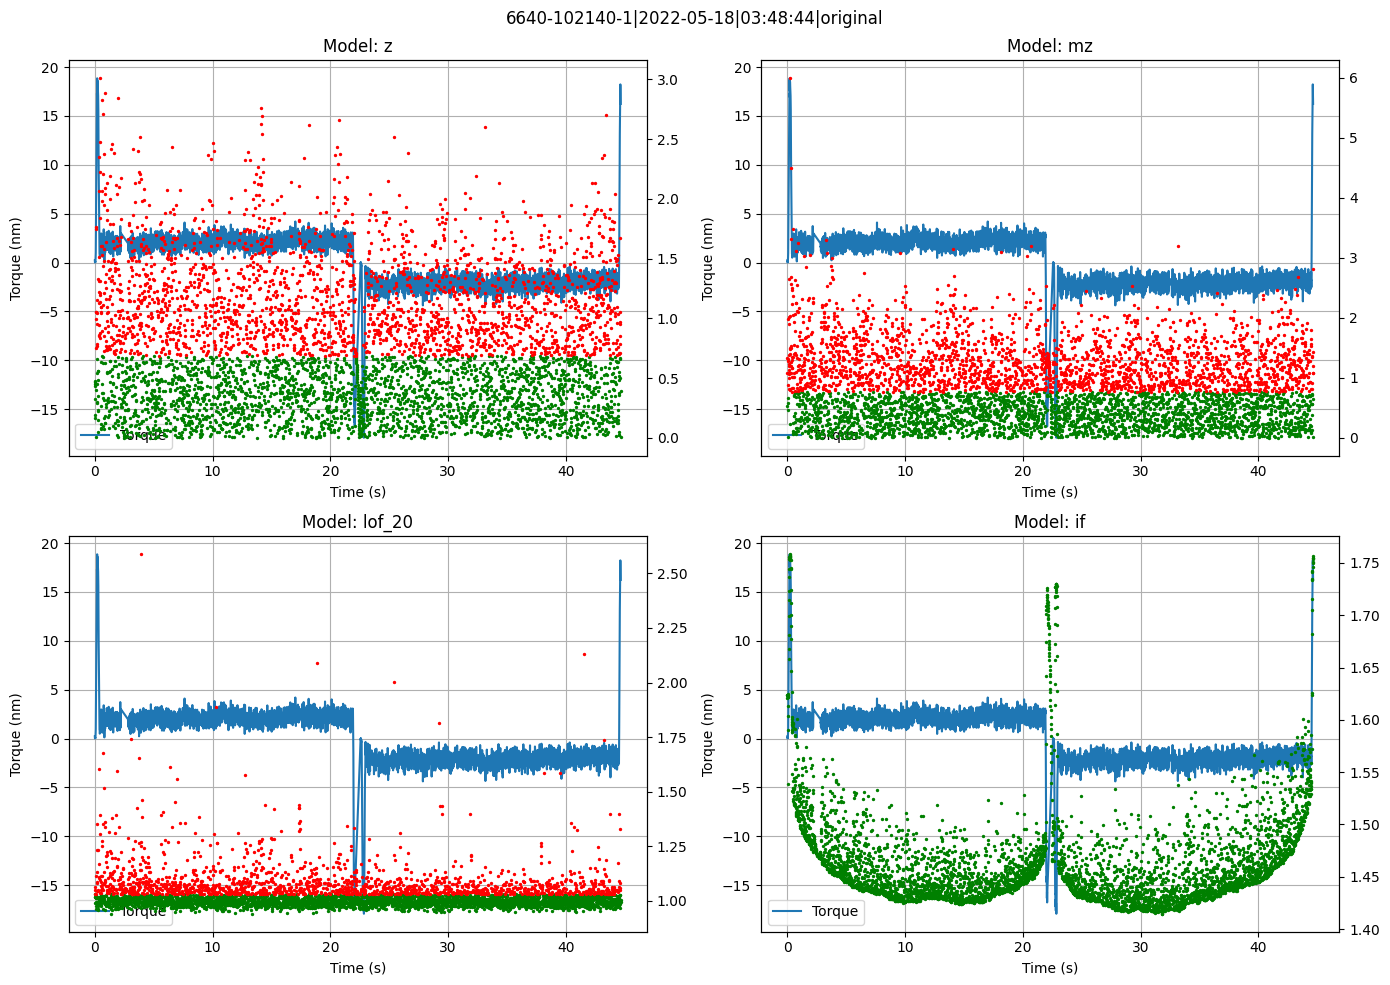

0.6864053832368587
0.7658369844631222
1.0300093725892716
2.1791111972304797


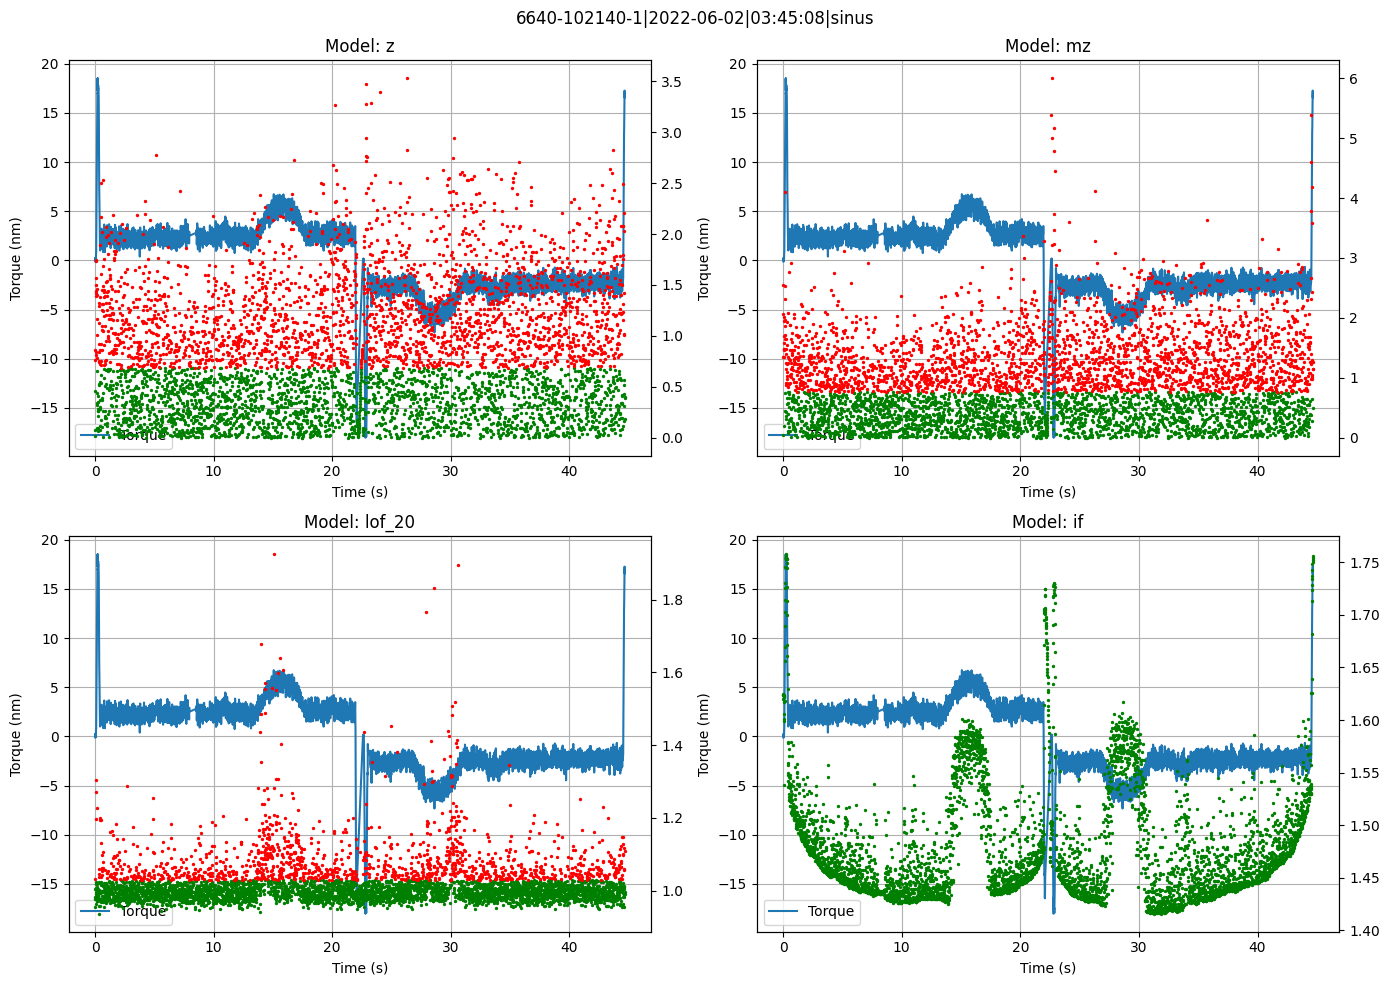

In [ ]:

modelnames = ['z', 'mz', 'lof_20', 'if']
seqid_org = np.random.choice([seqid for seqid in exp.results['df']['seqid'].unique() if 'original' in seqid])
seqid_sinus = np.random.choice([seqid for seqid in exp.results['df']['seqid'].unique() if 'sinus' in seqid])

plot_multiple([lambda ax, name=name: _plot_experiments(exp, name, ax, seqid_org) for name in modelnames], title=f"{seqid_org}", colnums=2, colsize=7)
plot_multiple([lambda ax, name=name: _plot_experiments(exp, name, ax, seqid_gauss) for name in modelnames], title=f"{seqid_sinus}", colnums=2, colsize=7)

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_gaussian.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=True)
        

z_sinusoidal_0.1_0.25_6640-102140-1
z_sinusoidal_0.1_0.5_6640-102140-1
z_sinusoidal_0.1_1_6640-102140-1
z_sinusoidal_0.1_2_6640-102140-1
mz_sinusoidal_0.1_0.25_6640-102140-1
mz_sinusoidal_0.1_0.5_6640-102140-1
mz_sinusoidal_0.1_1_6640-102140-1
mz_sinusoidal_0.1_2_6640-102140-1
lof_20_sinusoidal_0.1_0.25_6640-102140-1
lof_20_sinusoidal_0.1_0.5_6640-102140-1
lof_20_sinusoidal_0.1_1_6640-102140-1
lof_20_sinusoidal_0.1_2_6640-102140-1
if_sinusoidal_0.1_0.25_6640-102140-1
if_sinusoidal_0.1_0.5_6640-102140-1
if_sinusoidal_0.1_1_6640-102140-1
if_sinusoidal_0.1_2_6640-102140-1


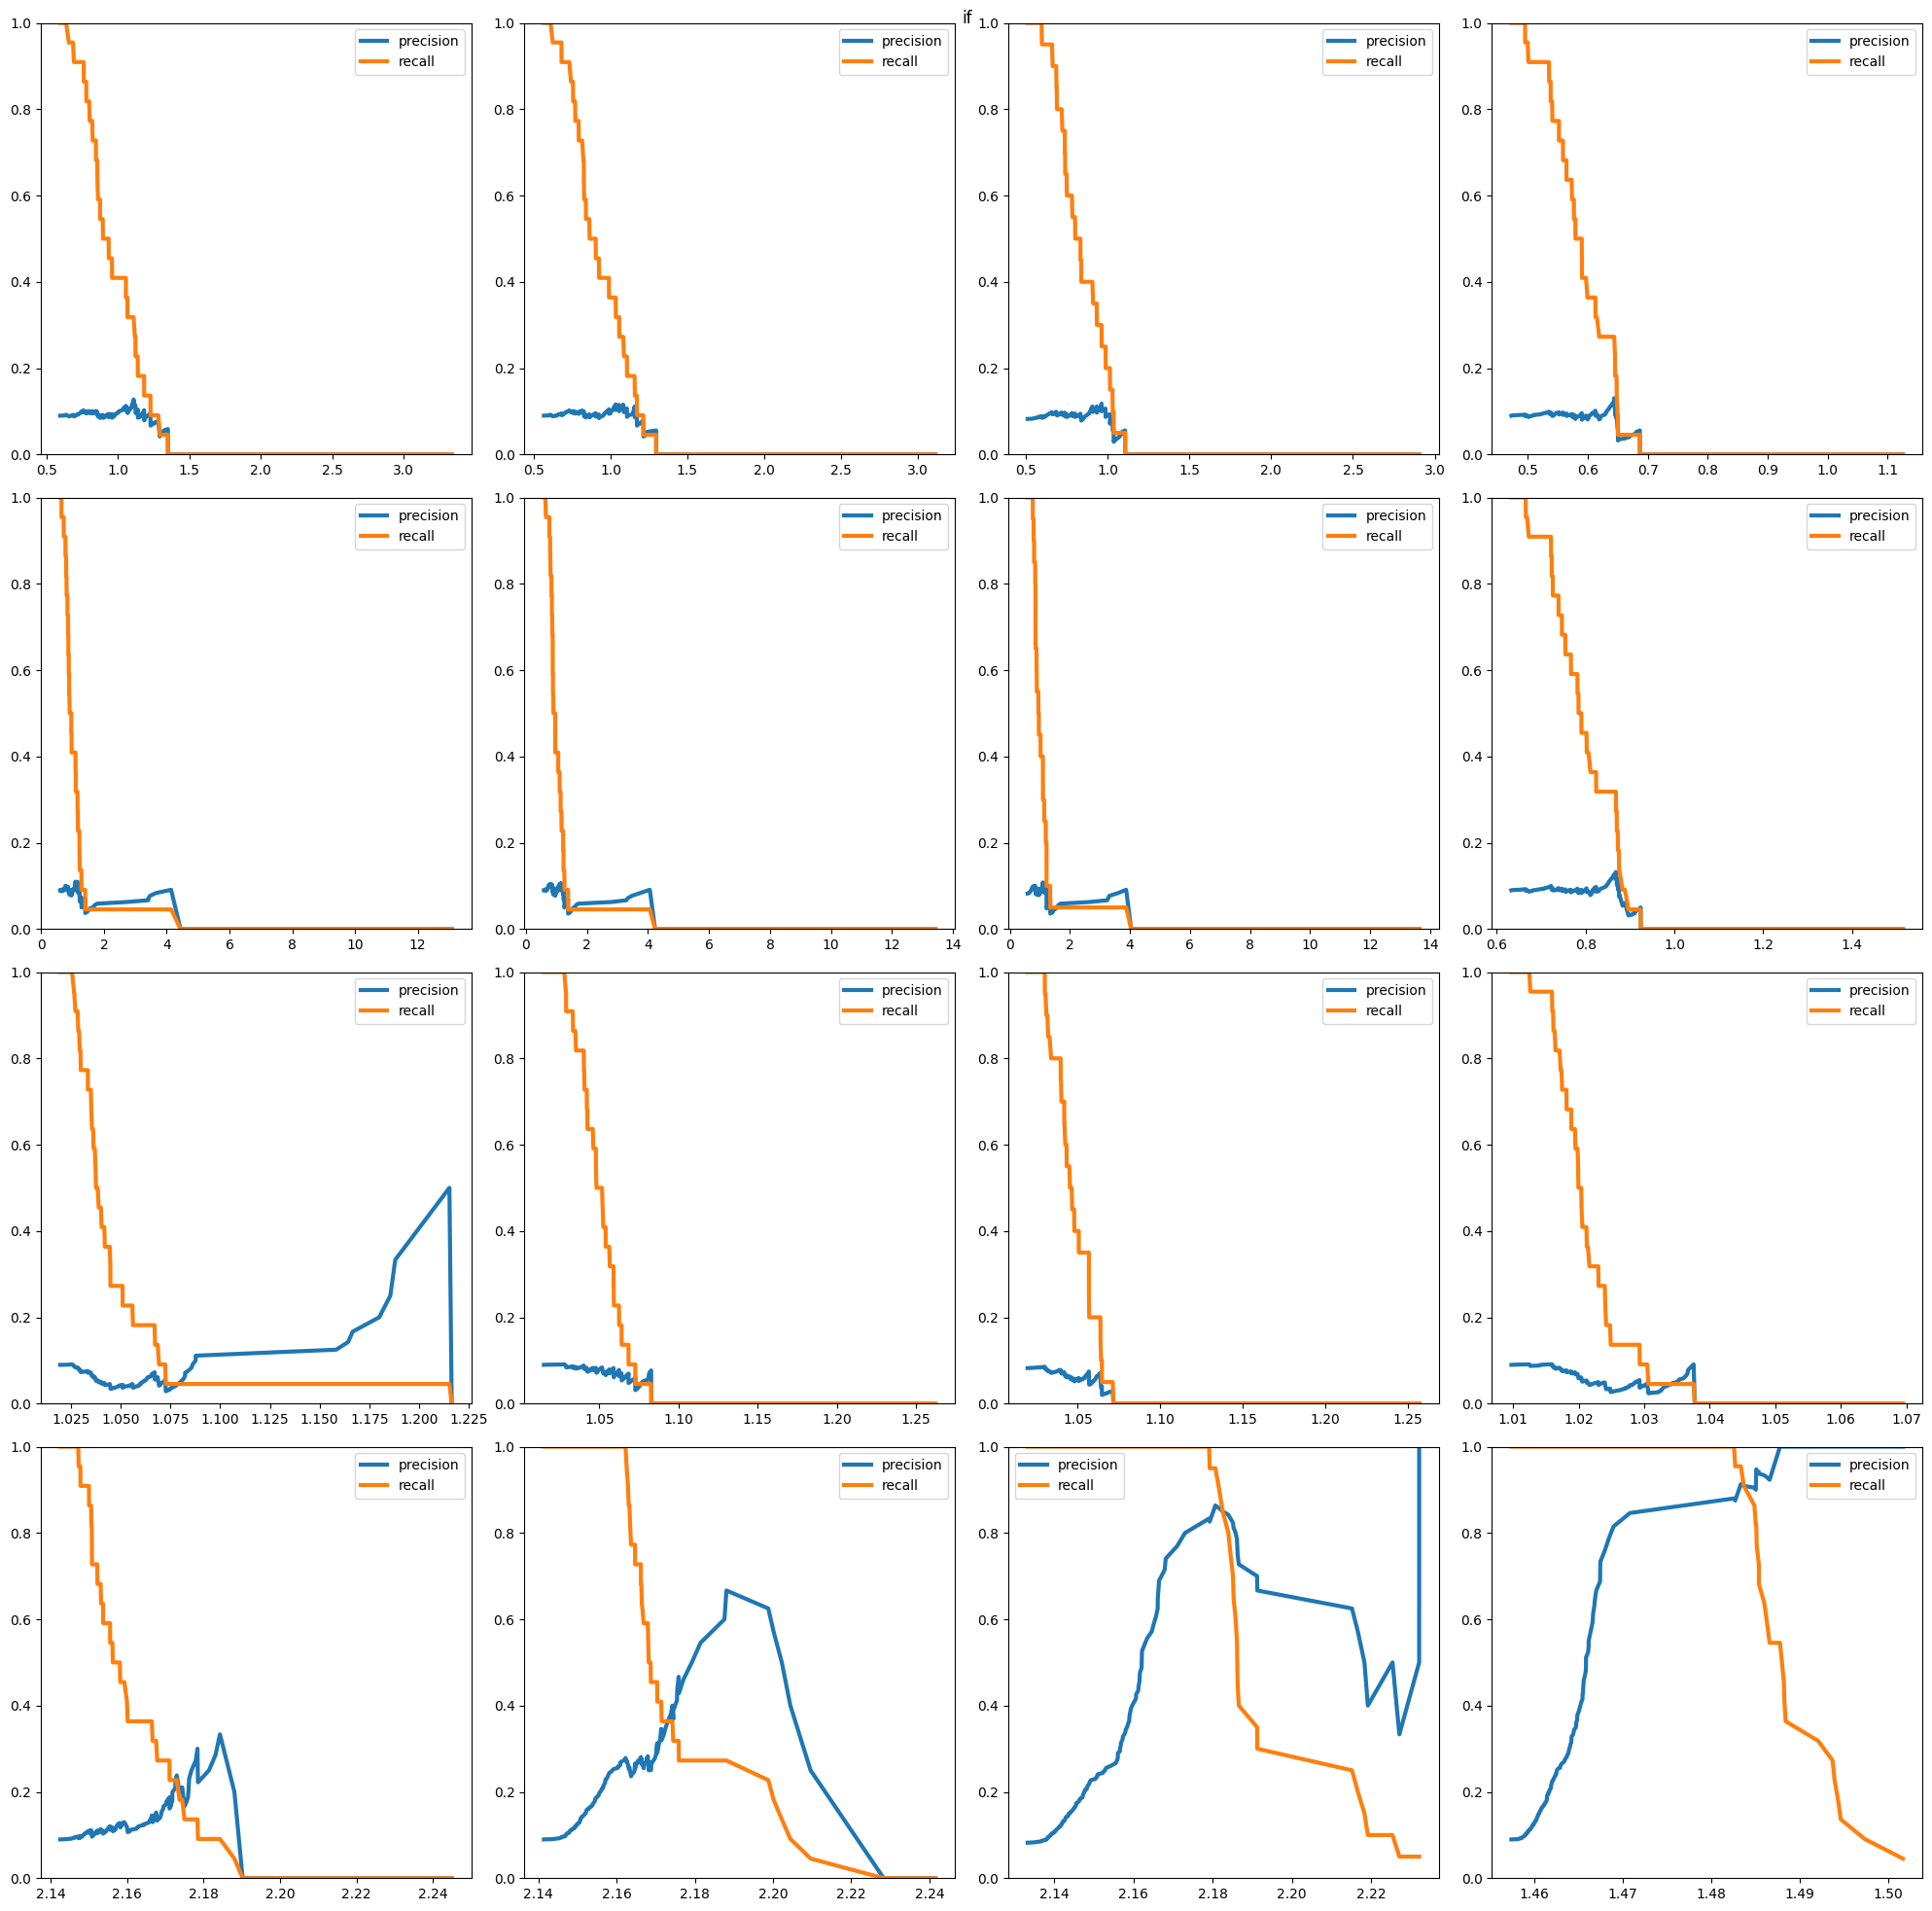

In [30]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_sinusoid.items():
        print(f"{mname}_{ename}")
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False, linewidth=3)

# SINUSOIDAL

In [ ]:
# Load or Run Experiments, depending on load_experiments
exps_sinusoidal = load_or_run_experiments(load_experiments, sinusoidal_params, name_sinusoidal_experiment, run_sinusoidal_experiment, df_in, models, exp_columns, syn_column, synratio, ids)



In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_sinusoidal.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=False)
        

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_sinusoidal.items():
        print(f"{mname}_{ename}")
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False, linewidth=3)

# POINT

In [ ]:
# Load or Run Experiments, depending on load_experiments
exps_point = load_or_run_experiments(load_experiments, point_params, name_point_experiment, run_point_experiment, df_in, models, exp_columns, syn_column, synratio, ids)

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    rp_curves[mname] = {}
    for (ename, exp) in exps_point.items():
        rp_curves[mname][ename] = exp.results['pr'][mname]
    with warnings.catch_warnings(action="ignore"):
        plot_rpcurves(rp_curves[mname], colnums=4, title=mname, auc=True, f1=False)
        

In [ ]:
rp_curves = {}
for exp in models:
    mname = exp.name
    for (ename, exp) in exps_point.items():
        print(f"{mname}_{ename}")
        rp_curves[f"{mname}_{ename}"] = exp.results['pr'][mname]


with warnings.catch_warnings(action="ignore"):
    plot_rpcurves(rp_curves, colnums=4, title=mname, auc=True, f1=False, showtitle=False)

In [ ]:
# for intensity in [0.025, 0.05, 0.075, 0.1, 0.125, 0.15]:
#     print(f"Running Experiment gaussian {intensity}")
#     run_gaussian_experiment(df_in, models, ['torqueactual'], 0.1, intensity)
# for intensity in [0.25, 0.5, 0.75, 1, 1.25, 1.5]:
#     print(f"Running Experiment point {intensity}")
#     run_point_experiment(df_in, models, ['torqueactual'], 0.1, intensity)
#     print(f"Running Experiment sinusoidal {intensity}")
#     run_sinusoidal_experiment(df_in, models, ['torqueactual'], 0.1, intensity)

In [ ]:
folder_path = g.experiments_folder_path

files_to_unpickle = [
    file for file in os.listdir(folder_path)
    if os.path.isfile(os.path.join(folder_path, file)) and file.endswith("6640-102140-1")
]

files_to_unpickle


In [ ]:
unpickled_data = {}
for file_name in files_to_unpickle:
    unpickled_data[file_name] = Experiment.unpickle(file_name)    
    
for (name, exp) in unpickled_data.items():
    print(f"{name} - {exp.results['auc-pr']}")